In [ ]:
import json
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyxray as xy
import seaborn as sb
import xraydb
import uuid

from json_to_np import *

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.usetex": True,
    "font.size": 8,
    "pgf.rcfonts": False
})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)
# plt.rcParams.update({'font.size': 8})

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
          r"\usepackage{mathtools}",
     ]),
})

mac = hex(uuid.getnode())
print(f"MAC address: {mac}")

mac_dict = {'0xb6ab0b4445f9': ['C://Users//schum//Documents//Filing Cabinet//1_RootFilesGeant4', 'C://Users//schum//Documents//Filing Cabinet//2_jsonFiles'], # Office
            '0x145afc4fe836': ['C://Users//schum//Documents//root_files_temp_storage', 'C://Users//schum//Documents//json_files_temp_storage'], # Laptop
            '0x1a7dda7115'  : ['B://IBA//root', 'B://IBA//json']} # Home PC
# Each mac adresse leads to a pair of paths, the first being the folder, 
# where the root files are, the second, where the json files are supposed to be stored
# root_path = mac_dict[mac][0]
json_path = mac_dict[mac][1]

MAC address: 0xb6ab0b4445f9


In [ ]:
def array_to_histo(data, mask_max = 1000):
    '''
    data = numpy array \n
    mask_max = float; in keV
    '''
    B = int(mask_max/0.12)
    plt.figure(figsize=(6,4), dpi=250)
    plt.hist(data[data <= mask_max], bins=B, color='firebrick', edgecolor='firebrick', zorder=2)
    plt.xlabel('Ekin')
    plt.ylabel('Counts')
    plt.yscale('linear')
    # plt.ylim(0,500)
    # plt.xlim(8,10)
    plt.title("Histogramm von Ekin")
    plt.grid(True, zorder=1)
    plt.tight_layout()
    plt.show()

In [4]:
data = json_to_np(json_path + "//BonnPIXE2_Blade15_Front17544_PIXE_1.json" , json_field='all')
# print(data)



True
Array for key Ekin created. 1/3
Array for key theta created. 2/3
Array for key phi created. 3/3


ValueError: `bins` must be positive, when an integer

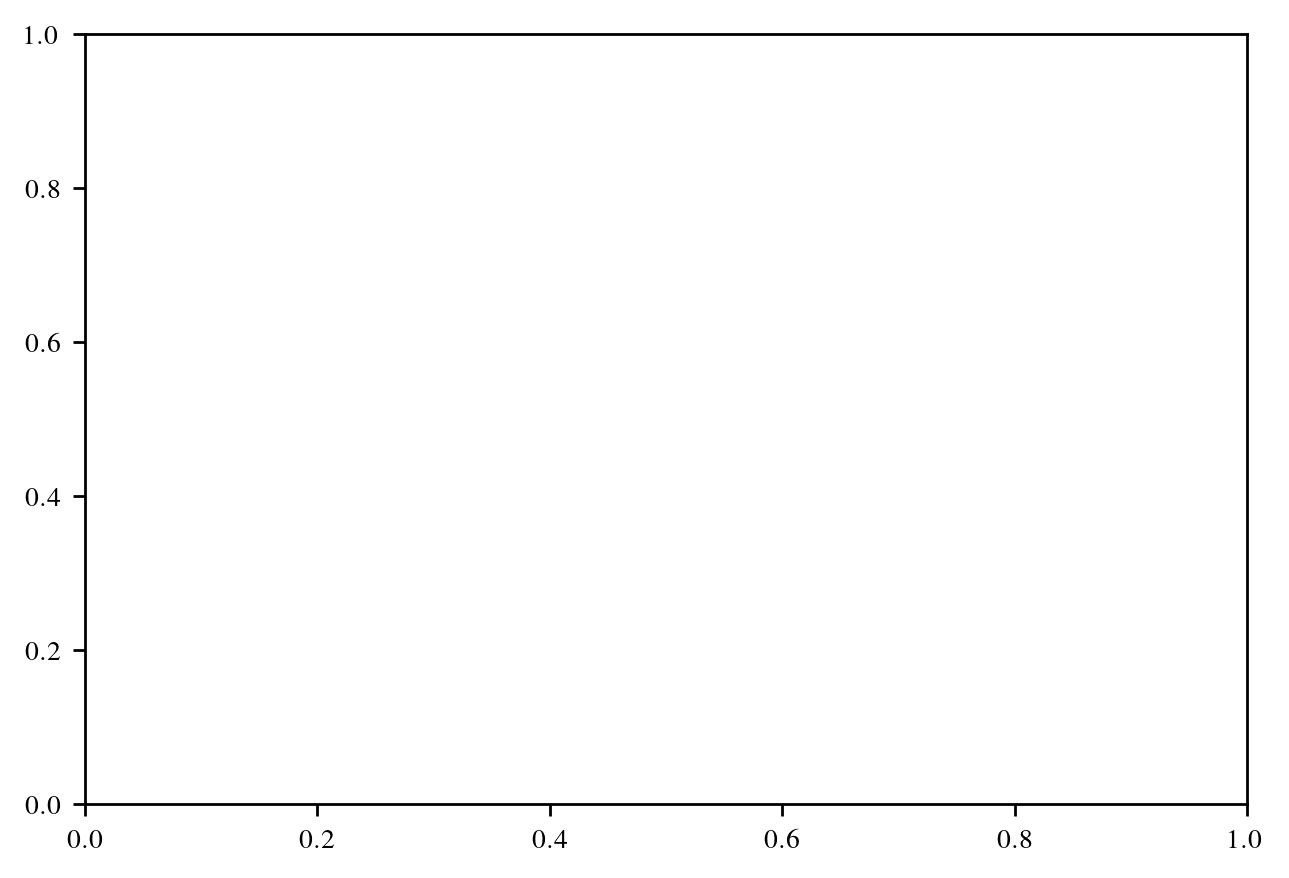

In [ ]:
array_to_histo(data['Ekin'], mask_max=100)

In [8]:
xy.xray_transition_energy_eV(25, 'La1')

637.0